In [1]:
# most common used packages for DSP, have a look into other scipy submodules
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal


def my_xcorr2(x, y, scaleopt='none'):
    N = len(x)
    M = len(y)
    kappa = np.arange(0, N+M-1) - (M-1)
    ccf = signal.correlate(x, y, mode='full', method='auto')
    if N == M:
        if scaleopt == 'none' or scaleopt == 'raw':
            ccf /= 1
        elif scaleopt == 'biased' or scaleopt == 'bias':
            ccf /= N
        elif scaleopt == 'unbiased' or scaleopt == 'unbias':
            ccf /= (N - np.abs(kappa))
        elif scaleopt == 'coeff' or scaleopt == 'normalized':
            ccf /= np.sqrt(np.sum(x**2) * np.sum(y**2))
        else:
            print('scaleopt unknown: we leave output unnormalized')
    return kappa, ccf

h[0]=0.014, DC=0.298 dB


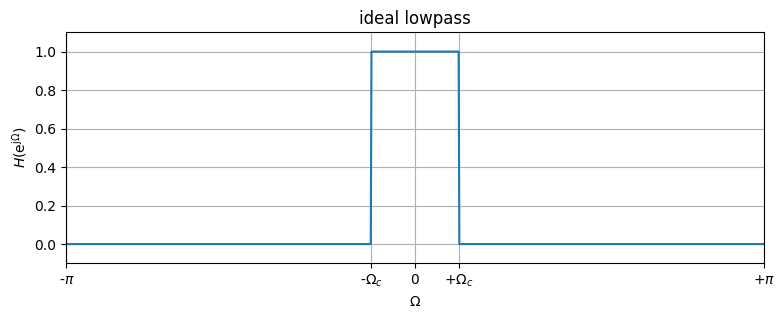

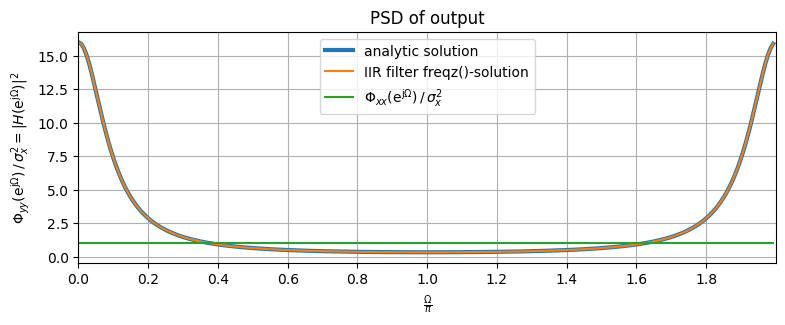

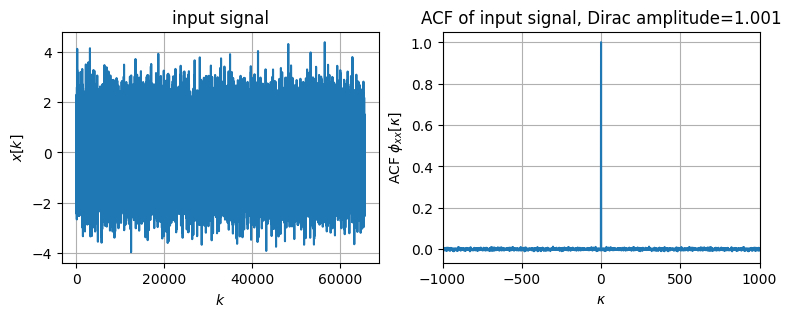

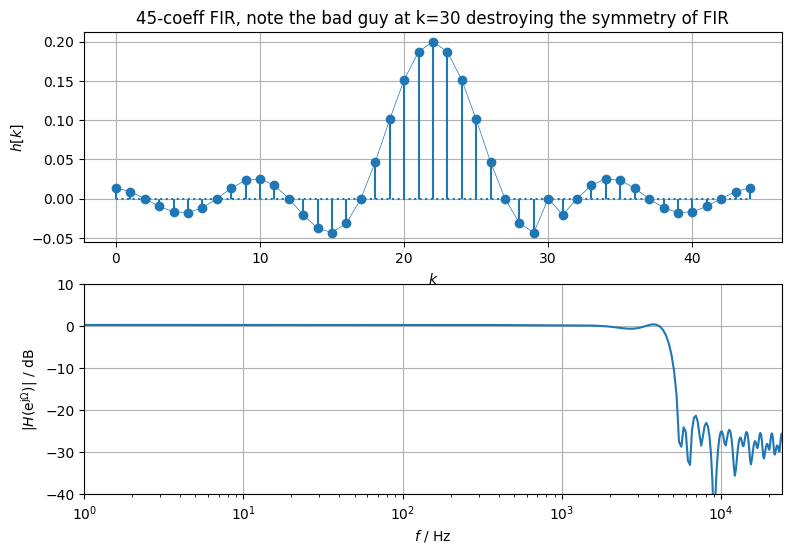

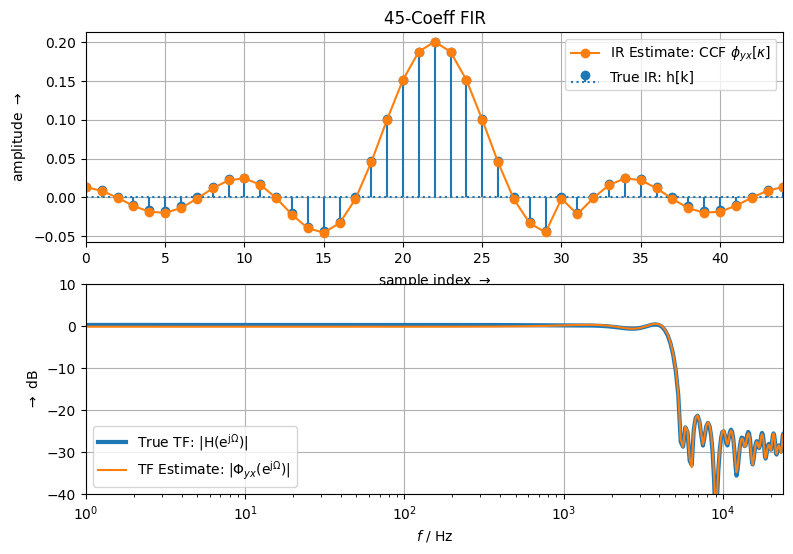

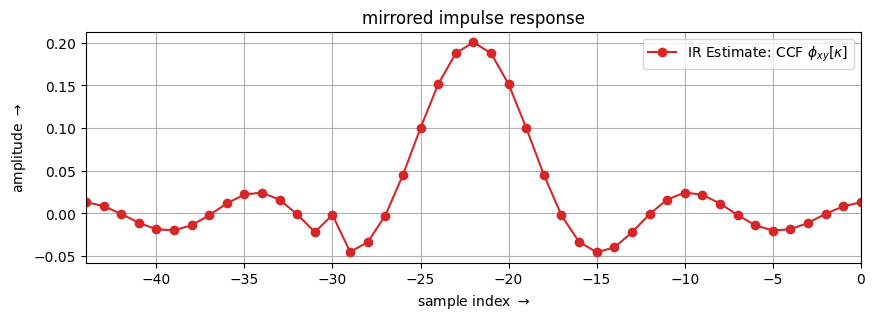

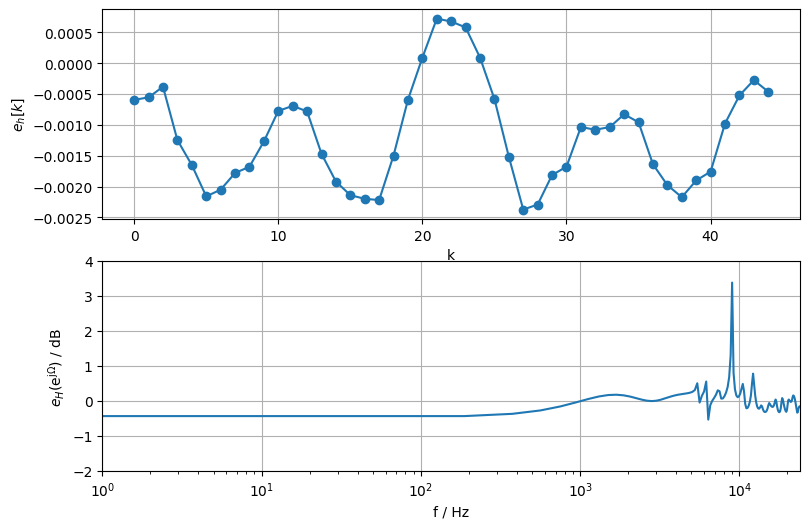

In [2]:
Omegac = np.pi/8  # arbitrary choice, must be <pi
N = 2**10
Omega = np.arange(N) * 2*np.pi/N - np.pi  # [-pi...pi)
H = np.ones(N)
H[Omegac < np.abs(Omega)] = 0
plt.figure(figsize=(9, 3))
plt.plot(Omega, H)
plt.xlabel(r'$\Omega$')
plt.ylabel(r'$H(\mathrm{e}^{\mathrm{j}\Omega})$')
plt.title('ideal lowpass')
plt.xticks([-np.pi, -Omegac, 0, +Omegac, +np.pi],
           [r'-$\pi$', r'-$\Omega_c$', '0', r'+$\Omega_c$', r'+$\pi$'])
plt.xlim(-np.pi, +np.pi)
plt.ylim(-0.1, 1.1)
plt.grid(True)

N = 2**8
Omega = np.arange(N) * 2*np.pi/N
H2 = 2 / (25/8 - 3*np.cos(Omega))  # analytic
Omega, H_IIR = signal.freqz(b=(1), a=(1, -3/4), worN=Omega)  # numeric

plt.figure(figsize=(9, 3))
plt.plot(Omega/np.pi, H2, lw=3, label='analytic solution')
plt.plot(Omega/np.pi, np.abs(H_IIR)**2, label='IIR filter freqz()-solution')
plt.plot(Omega/np.pi, Omega*0+1,
         label=r'$\Phi_{xx}(\mathrm{e}^{\mathrm{j}\Omega})\,/\,\sigma_x^2$')
plt.xlabel(r'$\frac{\Omega}{\pi}$')
plt.ylabel(
    r'$\Phi_{yy}(\mathrm{e}^{\mathrm{j}\Omega})\,/\,\sigma_x^2 = |H(\mathrm{e}^{\mathrm{j}\Omega})|^2$')
plt.title('PSD of output')
plt.xlim(0, 2)
plt.xticks(np.arange(0, 20, 2)/10)
plt.legend()
plt.grid(True)

np.random.seed(2)  # arbitrary choice
Nx = 2**16
k = np.arange(Nx)
x = np.random.randn(Nx)
kappa, phixx = my_xcorr2(x, x, 'biased')  # we use biased here, i.e. 1/N normalization
idx = np.where(kappa==0)[0][0]

plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.plot(k, x)
plt.xlabel('$k$')
plt.ylabel('$x[k]$')
plt.title('input signal')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(kappa, phixx)
plt.xlim(-1000, +1000)
plt.xlabel('$\kappa$')
plt.ylabel('ACF $\phi_{xx}[\kappa]$')
plt.title('ACF of input signal, Dirac amplitude=%4.3f' % phixx[idx])
plt.grid(True)

fs = 48000  # sampling frequency in Hz
fc = 4800  # cut frequency in Hz
number_fir_coeff = 45  # FIR taps
h = signal.firls(numtaps=number_fir_coeff,  # example for demo
                 bands=(0, fc, fc+1, fs//2),
                 desired=(1, 1, 0, 0),
                 fs=fs)
Nh = h.size
k = np.arange(Nh)
# make the IR unsymmetric by arbitray choice for demonstration purpose
idx = 30
h[idx] = 0  # then FIR is not longer linear-phase, see the spike in the plot

print('h[0]={0:4.3f}, DC={1:4.3f} dB'.format(h[0], 20*np.log10(np.sum(h))))

N = 2**8
Omega = np.arange(0, N) * 2*np.pi/N
_, H = signal.freqz(b=h, a=1, worN=Omega)

plt.figure(figsize=(9, 6))
plt.subplot(2, 1, 1)
plt.stem(k, h, basefmt='C0:')
plt.plot(k, h, 'C0-', lw=0.5)
plt.xlabel(r'$k$')
plt.ylabel(r'$h[k]$')
plt.title(str(Nh)+'-coeff FIR, note the bad guy at k=%d destroying the symmetry of FIR' % idx)
plt.grid(True)
plt.subplot(2, 1, 2)
plt.semilogx(Omega / (2*np.pi) * fs, 20*np.log10(np.abs(H)))
plt.xlabel(r'$f$ / Hz')
plt.ylabel(r'$|H(\mathrm{e}^{\mathrm{j}\Omega})|$ / dB')
plt.xlim(1, fs//2)
plt.ylim(-40, 10)
plt.grid(True)

y = np.convolve(x, h, mode='full')  # signal x through system h returns output y

kappa, phiyx = my_xcorr2(y, x, 'biased')  # get cross correlation in order y,x

# find the index for kappa=0, the IR starts here
idx = np.where(kappa == 0)[0][0]
# cut out the IR, since we know the numtaps this is easy to decide here
h_est = phiyx[idx:idx+Nh] / len(y)
# get DTFT estimate of PSD
_, Phiyx = signal.freqz(b=h_est, a=1, worN=Omega)

plt.figure(figsize=(9, 6))
plt.subplot(2, 1, 1)
plt.stem(h, basefmt='C0:', label='True IR: h[k]')
plt.plot(kappa, phiyx / len(y), 'C1o-',
         label=r'IR Estimate: CCF $\phi_{yx}[\kappa]$')
plt.xlim(0, Nh-1)
plt.xlabel(r'sample index $\rightarrow$')
plt.ylabel(r'amplitude $\rightarrow$')
plt.title(str(Nh)+'-Coeff FIR')
plt.legend()
plt.grid(True)
plt.subplot(2, 1, 2)
plt.semilogx(Omega/2/np.pi*fs, 20*np.log10(np.abs(H)), lw=3,
             label=r'True TF: $|\mathrm{H}(\mathrm{e}^{\mathrm{j}\Omega})|$')
plt.semilogx(Omega/2/np.pi*fs, 20*np.log10(np.abs(Phiyx)),
             label='TF Estimate: $|\Phi_{yx}(\mathrm{e}^{\mathrm{j}\Omega})|$')
plt.xlabel(r'$f$ / Hz')
plt.ylabel(r'$\rightarrow$ dB')
plt.xlim(1, fs//2)
plt.ylim(-40, 10)
plt.legend()
plt.grid(True)

kappa, phixy = my_xcorr2(x, y, 'biased')  # get cross correlation x,y

plt.figure(figsize=(10, 3))
plt.plot(kappa, phixy/len(y), 'C3o-',
         label=r'IR Estimate: CCF $\phi_{xy}[\kappa]$')
plt.xlim(-(Nh-1), 0)
plt.xlabel(r'sample index $\rightarrow$')
plt.ylabel(r'amplitude $\rightarrow$')
plt.title('mirrored impulse response')
plt.legend()
plt.grid(True)

plt.figure(figsize=(9, 6))
plt.subplot(2, 1, 1)
plt.plot(h_est - h, 'o-')
plt.xlabel('k')
plt.ylabel(r'$e_h[k]$')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.semilogx(Omega / (2*np.pi) * fs, 20 *
             np.log10(np.abs(Phiyx)) - 20*np.log10(np.abs(H)))
plt.xlabel('f / Hz')
plt.ylabel(r'$e_H(\mathrm{e}^{\mathrm{j}\Omega})$ / dB')
plt.xlim(1, fs//2)
plt.ylim(-2, 4)
plt.grid(True)